### Film reviews sentiment analysis

##### Loading and preparing data

In [1]:
import numpy as np
import pandas as pd
import plotly.express as px
import sklearn

In [2]:
np.random.seed(42)

In [3]:
!wget https://raw.githubusercontent.com/nltk/nltk_data/gh-pages/packages/corpora/movie_reviews.zip

--2023-03-14 12:14:36--  https://raw.githubusercontent.com/nltk/nltk_data/gh-pages/packages/corpora/movie_reviews.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4004848 (3.8M) [application/zip]
Saving to: ‘movie_reviews.zip’

movie_reviews.zip   100%[===================>]   3.82M  --.-KB/s    in 0.03s   

2023-03-14 12:14:37 (123 MB/s) - ‘movie_reviews.zip’ saved [4004848/4004848]



In [4]:
!unzip -q movie_reviews.zip

In [5]:
!pwd
!ls

/content
movie_reviews  movie_reviews.zip  sample_data


In [6]:
from sklearn.datasets import load_files

movie_raw = load_files('movie_reviews')
movie = movie_raw.copy()
movie.keys()

dict_keys(['data', 'filenames', 'target_names', 'target', 'DESCR'])

In [7]:
movie['data'][0]

b"arnold schwarzenegger has been an icon for action enthusiasts , since the late 80's , but lately his films have been very sloppy and the one-liners are getting worse . \nit's hard seeing arnold as mr . freeze in batman and robin , especially when he says tons of ice jokes , but hey he got 15 million , what's it matter to him ? \nonce again arnold has signed to do another expensive blockbuster , that can't compare with the likes of the terminator series , true lies and even eraser . \nin this so called dark thriller , the devil ( gabriel byrne ) has come upon earth , to impregnate a woman ( robin tunney ) which happens every 1000 years , and basically destroy the world , but apparently god has chosen one man , and that one man is jericho cane ( arnold himself ) . \nwith the help of a trusty sidekick ( kevin pollack ) , they will stop at nothing to let the devil take over the world ! \nparts of this are actually so absurd , that they would fit right in with dogma . \nyes , the film is 

In [8]:
len(movie['data'])

2000

In [9]:
len(movie['target'])

2000

In [10]:
movie['target'][0]

0

In [11]:
movie['target_names']

['neg', 'pos']

In [12]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(movie['data'], movie['target'], random_state=42, test_size=0.2)

print('X_train: ', len(X_train))
print('X_test: ', len(X_test))

X_train:  1600
X_test:  400


In [13]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(max_features=4000)
X_train = tfidf.fit_transform(X_train)

In [14]:
# Test set only model fit - not transform
X_test = tfidf.transform(X_test)

In [15]:
print('X_train shape: ', X_train.shape)
print('X_test shape: ', X_test.shape)

X_train shape:  (1600, 4000)
X_test shape:  (400, 4000)


##### Predictions with naive bayes clasifier

In [16]:
from sklearn.naive_bayes import MultinomialNB

classifier = MultinomialNB()
classifier.fit(X_train, y_train)
classifier.score(X_test, y_test)

0.805

In [17]:
from sklearn.metrics import confusion_matrix

y_pred = classifier.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
cm

array([[165,  25],
       [ 53, 157]])

(<Figure size 432x288 with 1 Axes>,
 <AxesSubplot:xlabel='predicted label', ylabel='true label'>)

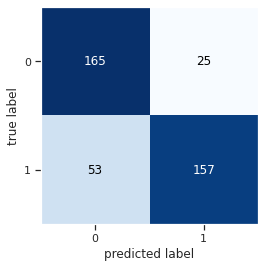

In [18]:
from sklearn.metrics import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix
import seaborn as sns
sns.set()

cm = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(cm)

In [19]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.76      0.87      0.81       190
           1       0.86      0.75      0.80       210

    accuracy                           0.81       400
   macro avg       0.81      0.81      0.80       400
weighted avg       0.81      0.81      0.80       400



#### Predictions with random forrest clasifier

In [21]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

param_grid = {'n_estimators' : [20, 50, 100, 200],
              'criterion': ['gini', 'entropy'],
              'max_depth' : [3, 4, 5, 7, 10, 15],
              'min_samples_leaf' : [1, 5, 10]}


rf_classifier = RandomForestClassifier(random_state=42)

rf_grid_search = GridSearchCV(rf_classifier, param_grid=param_grid, n_jobs=-1, scoring='accuracy', cv=10)
rf_grid_search.fit(X_train, y_train)

GridSearchCV(cv=10, estimator=RandomForestClassifier(random_state=42),
             n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [3, 4, 5, 7, 10, 15],
                         'min_samples_leaf': [1, 5, 10],
                         'n_estimators': [20, 50, 100, 200]},
             scoring='accuracy')

In [22]:
rf_grid_search.best_params_

{'criterion': 'gini',
 'max_depth': 15,
 'min_samples_leaf': 1,
 'n_estimators': 200}

In [23]:
rf_y_pred = rf_grid_search.predict(X_test)
rf_y_pred[0:10]

array([0, 0, 1, 1, 0, 0, 1, 1, 0, 1])

In [24]:
from sklearn.metrics import accuracy_score

acc = accuracy_score(y_test, rf_y_pred)
print('Accuracy: ', acc)

Accuracy:  0.8225


(<Figure size 432x288 with 1 Axes>,
 <AxesSubplot:xlabel='predicted label', ylabel='true label'>)

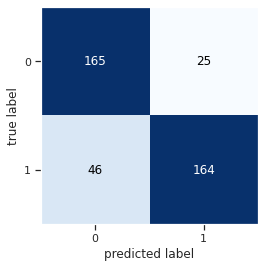

In [25]:
cm = confusion_matrix(y_test, rf_y_pred)
plot_confusion_matrix(cm)

In [26]:
print(classification_report(y_test, rf_y_pred))

              precision    recall  f1-score   support

           0       0.78      0.87      0.82       190
           1       0.87      0.78      0.82       210

    accuracy                           0.82       400
   macro avg       0.82      0.82      0.82       400
weighted avg       0.83      0.82      0.82       400



#### Let's try to predict sentiment of some reviews from rottentomatoes.com

In [27]:
new_reviews = ['A truly atrocious mini-series that adds next to nothing to the main show, and doesn’t seem concerned in the slightest with the source material. It’s dull and makes big changes to The Witcher lore for no discernible reason.', 
               'The problems lie almost entirely in the ways it has forced its connective tissue to the main Witcherverse because they don’t make any sense. The creative decisions are kinda dumb. Wrong-headed, even. Bad.',
               'Not as graphic as last season\'s bloodbath down the aisle, the death count in last night\'s episode is a game changer, though perhaps not as surprising this time around. All men must die, sure, but do they all have to die at a wedding?',
               'Delightfully bonkers on the surface, this inventive extravaganza from the directing team called Daniels (Daniel Kwan and Daniel Scheinert) has a deep layer of family feeling and a well-earned emotional pull at the end.',
               'In The Lord of the Rings film trilogy, we were witness to the Battle of Helm\'s Deep five hours in. Five hours into The Rings of Power, we saw the series tread water.',
               'This soulful sequel teams an emotional tribute to late star Chadwick Boseman with some spectacular visual action. A maturity milestone for the Marvel Cinematic Universe, starring Angela Bassett and Winston Duke.',
               'The film’s focus is split in so many directions that none of its characters feel whole, even after three full hours.',
               'Why not strip it down to the sincere basics? Get the family out of the forest faster, and for a more respectable reason. In fact, the subplot of the forest family living among the water people is way better than the main plot. Gorgeous though.',
               'The more appealing thing about the whole enterprise is the mental image of these former A-listers hanging out between takes, swapping stories of the old days and competing over who least understands the script.',
               'The visuals are so busy, the jokes so tame, the homilies so overfamiliar, the only option is surrendering to the chaos. But those pros Pfeiffer and Douglas up the game with an interstellar Romancing the Stone vibe.',
               'First season was bland. This season is flat boring. It\'s obvious what helped season one was being introduced to the characters and the crush on the lead. All of that is gone and the show is now just boring and bad.',
               'A god awful show that is one of the worst written sitcoms I\'ve ever watched. With all the great shows out there why would Hulu put this one on its platform?',
               'He isn’t flawless, and the film is damning of his realpolitik approach to coalition-building with some scummy far-right politicians, but he’s an inspiring figure for his sheer fearlessness in the face of tryanny.'               ]

new_reviews_ratings = [0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1]

new_reviews_transformed = tfidf.transform(new_reviews)
new_reviews_transformed

<13x4000 sparse matrix of type '<class 'numpy.float64'>'
	with 320 stored elements in Compressed Sparse Row format>

In [28]:
new_reviews_transformed.toarray()

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [29]:
new_reviews_pred_nb = classifier.predict(new_reviews_transformed)
new_reviews_pred_nb

array([0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1])

In [30]:
new_reviews_prob_nb = classifier.predict_proba(new_reviews_transformed)
new_reviews_prob_nb

array([[0.64180958, 0.35819042],
       [0.62240928, 0.37759072],
       [0.48559041, 0.51440959],
       [0.50593548, 0.49406452],
       [0.51569609, 0.48430391],
       [0.43123022, 0.56876978],
       [0.51252066, 0.48747934],
       [0.60444148, 0.39555852],
       [0.52747057, 0.47252943],
       [0.54925739, 0.45074261],
       [0.64409513, 0.35590487],
       [0.6862417 , 0.3137583 ],
       [0.42136233, 0.57863767]])

In [31]:
new_reviews_pred_rf = rf_grid_search.predict(new_reviews_transformed)
new_reviews_pred_rf

array([0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1])

In [32]:
new_reviews_prob_rf = classifier.predict_proba(new_reviews_transformed)
new_reviews_prob_rf

array([[0.64180958, 0.35819042],
       [0.62240928, 0.37759072],
       [0.48559041, 0.51440959],
       [0.50593548, 0.49406452],
       [0.51569609, 0.48430391],
       [0.43123022, 0.56876978],
       [0.51252066, 0.48747934],
       [0.60444148, 0.39555852],
       [0.52747057, 0.47252943],
       [0.54925739, 0.45074261],
       [0.64409513, 0.35590487],
       [0.6862417 , 0.3137583 ],
       [0.42136233, 0.57863767]])

In [37]:
comparison = pd.DataFrame(
    {'true' : new_reviews_ratings,
    'naive_bayes': new_reviews_pred_nb,
    'random_forest' : new_reviews_pred_rf})

comparison

,true,naive_bayes,random_forest
0,0,0,0
1,0,0,0
2,1,1,1
3,1,0,1
4,0,0,1
5,1,1,1
6,0,0,1
7,1,0,0
8,0,0,1
9,1,0,1


In [38]:
print('Accracy on new reviews:')
print('Naive bayes ccuracy: ', accuracy_score(comparison['true'], comparison['naive_bayes']))
print('Random forest ccuracy: ', accuracy_score(comparison['true'], comparison['random_forest']))

Accracy on new reviews:
Naive bayes ccuracy:  0.7692307692307693
Random forest ccuracy:  0.6923076923076923
